# Table of Contents
 <p><div class="lev1 toc-item"><a href="#r/depression:-Analysis-of-All-Reddit-Comments" data-toc-modified-id="r/depression:-Analysis-of-All-Reddit-Comments-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>r/depression: Analysis of All Reddit Comments</a></div><div class="lev1 toc-item"><a href="#Dataset-Extraction-Recap" data-toc-modified-id="Dataset-Extraction-Recap-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dataset Extraction Recap</a></div><div class="lev1 toc-item"><a href="#Summary-Statistics" data-toc-modified-id="Summary-Statistics-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Summary Statistics</a></div><div class="lev2 toc-item"><a href="#Investigation-of-data-quality-for-body" data-toc-modified-id="Investigation-of-data-quality-for-body-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Investigation of data quality for <code>body</code></a></div><div class="lev2 toc-item"><a href="#Distribution-of-Parent-IDs" data-toc-modified-id="Distribution-of-Parent-IDs-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Distribution of Parent IDs</a></div><div class="lev2 toc-item"><a href="#Distribution-of-Authors" data-toc-modified-id="Distribution-of-Authors-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Distribution of Authors</a></div>

# r/depression: Analysis of All Reddit Comments

_By [Michael Rosenberg](mailto:rosenberg.michael.m@gmail.com)._

_**Description**: Contains a short analysis of all reddit comment data that I extracted from [Google BigQuery](https://www.reddit.com/r/bigquery/comments/3cej2b/17_billion_reddit_comments_loaded_on_bigquery/)._

_Last Updated: 10/22/2017 5:40 PM EST._

In [20]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#helpers
sigLev = 3
%matplotlib inline
sns.set_style("whitegrid")
pd.options.display.precision = sigLev

In [2]:
#load in data
commentFrame = pd.read_csv("../data/raw/allRDepressionData.csv")

# Dataset Extraction Recap

We downloaded this dataset on [Google BigQuery](https://www.reddit.com/r/bigquery/comments/3cej2b/17_billion_reddit_comments_loaded_on_bigquery/) using a variant of the command found [here](../code/rDepression_all.sql). This dataset was extracted on 10/22/2017.

This is a dataset of comments from the [r/depression](https://www.reddit.com/r/depression/) page. Note that this does not contain submissions, which will be extracted from another dataset later on.

# Summary Statistics

In [3]:
commentFrame.shape

(2023603, 21)

We see that this dataset contains $2$ Million Comments. This is a large amount of text to work with, although it isn't currently clear if this is large compared to other available subreddits.

In [4]:
commentFrame.columns

Index([u'body', u'score_hidden', u'archived', u'name', u'author',
       u'author_flair_text', u'downs', u'created_utc', u'subreddit_id',
       u'link_id', u'parent_id', u'score', u'retrieved_on',
       u'controversiality', u'gilded', u'id', u'subreddit', u'ups',
       u'distinguished', u'author_flair_css_class', u'removal_reason'],
      dtype='object')

We have a few variables that are relevant here:

* `body`: The text of the comment.

* `score_hidden`: a flag indicating whether the score was hidden. Currently, it is not clear if this option is available for this subreddit.

* `archived`: a flag indicating whether the thread was archived.

* `name`: not clear what this is yet; Let's do some exploration on this.

* `author`: the username of the author who wrote the comment.

* `author_flair_text`: the flair text indicated at the bottom of the author. Currently not clear if this is useful text, but we will consider it for now.

* `downs`: The number of downs on the score of the comment. It's not clear whether this has been censored or not. We should perhaps check this in our EDA.

* `created_utc`: the creation date of the comment in coordinated universal time. We will likely need to translate this into a datetime within Pandas to interpret the timeline of these comments.

* `subreddit_id`: the ID of the subreddit the comment was placed on. Again, since all subreddits in this dataset should be `depression`, we should only have one level of `subreddit_id` in this dataset.

* `link_id`: Not sure what this is yet. Might need to do some studying.

* `parent_id`: the ID of the item these comment is attached to. This indicates the first comment on the particular thread.

* `score`: The score of the comment as of 7/30/2017. My best guess is that this is the sum of upvotes and downvotes on a given comment.

* `retrieved_on`: not clear if this is when _we_ retrieve the comment or when another group of individuals have retrieved the comment._

* `constroversiality`: Some measure of how controversial a comment is. Not clear if these analytics are provided for this thread, but still useful to consider.

* `gilded`: Not clear what this is.

* `id`: ID of the comment.

* `subreddit`: This is the subreddit the comment was placed on. Currently, all subreddits in this dataset should be `depression`.

* `ups`: Number of ups on a comment. Not clear if this is provided by this thread or it is censored.

* `distinguished`: Not entirely sure what qualifies as a distinguished comment. Again, probably censored.

* `author_flair_css_class`: I guess this is the css class associated with the author flair text. Not sure if it's important to consider this when analyzing `author_flair_text`. I doubt it is.

* `removal_reason`: the reason for the removal of a particular comment. I am guessing this is a reason code that we will need to perform some lookups for to get the text-based reason for a removal. That being said, we will likely remove these types of comments from our analysis anyway.

In [6]:
#data quality check
numNullFrame = commentFrame.apply(lambda x: x[x.isnull()].shape[0],axis = 0)
numNullFrame

body                           47
score_hidden              1037364
archived                  1037364
name                      1037364
author                          0
author_flair_text         2023603
downs                     1037364
created_utc                     0
subreddit_id                    0
link_id                         0
parent_id                       0
score                           0
retrieved_on                 2767
controversiality                0
gilded                          0
id                              0
subreddit                       0
ups                        582300
distinguished             2019357
author_flair_css_class    2023603
removal_reason            2023603
dtype: int64

_Table 1: Number of Null observations in our dataset by column._

We see we have around $47$ bodies without information whatsoever. We also see sizable amount of nulls in:

* `score_hidden`

* `archived`

* `name`

* `author_flair_text`

* `downs`

* `ups`

* `distinguished`

* `author_flair_css_class`

* `removal_reason`

We see almost all observations with null counts for `author_flair_text`, `author_flair_css_class`, and `removal_reason`. For these reasons, we will remove them from the rest of our exploration.

In [7]:
#remove null bodies
filteredCommentFrame = commentFrame[commentFrame["body"].notnull()]

In [8]:
#drop  empty columns
droppedColumns = ["author_flair_text","author_flair_css_class",
                  "removal_reason"]
filteredCommentFrame = filteredCommentFrame.drop(droppedColumns,axis = 1)

In [10]:
#get number of levels
nUniqueFrame = filteredCommentFrame.apply(lambda x: x.nunique(),axis = 0)
nUniqueFrame

body                1711649
score_hidden              1
archived                  2
name                 985818
author               253371
downs                     1
created_utc         2005312
subreddit_id              1
link_id              328417
parent_id           1160632
score                   367
retrieved_on        1921960
controversiality          2
gilded                    4
id                  2021454
subreddit                 1
ups                     334
distinguished             1
dtype: int64

_Table 2: Number of Unique Levels per variable._

This provides us with quite a bit of information:

* We have many repeated types of comments. Perhaps this is part of the group that are removed from consideration.

* We have around 250K authors on this reddit. that's a rate of around $\frac{2000000}{250000} = \frac{200}{25} = 8$ comments per author. This suggest some moderate level of interaction on the site, Since I expected there to be more around $[1,2]$ comments per author.

* There are a little over $1$ million unique threads. This means there tends to be fewer than $2$ comments per thread, although we will likely see more distributional inequality further in our analysis.

## Investigation of data quality for `body`

In [14]:
bodyFrame = filteredCommentFrame.groupby("body",as_index = False)[
                                                                "score"].count()
bodyFrame = bodyFrame.rename(columns = {"score":"count"})
bodyFrame = bodyFrame.sort_values("count",ascending = False)
topLev = 30
bodyFrame.iloc[0:topLev]

,body,count
1590770,[deleted],208990
1591171,[removed],55613
1186318,Thank you.,997
1162179,Thank you,846
1180368,Thank you!,594
52559,:),535
1193066,Thanks,506
1162457,Thank you :),474
1212052,Thanks!,377
1088428,Same,359


_Table 3: Top Thirty Comments by count._

We see that there are a lot of [removed] and [deleted] observations in our dataset. While I don't yet know the difference between these two, they don't really express meaningful language content with the exception of context. Thus, I think I want to remove them from consideration from the dataset.

In [16]:
filteredCommentFrame = filteredCommentFrame[~(
            filteredCommentFrame["body"].isin(["[removed]","[deleted]"]))]
filteredCommentFrame.shape

(1758953, 18)

We are now down to a little under $1.8$ millions comments.

## Distribution of Parent IDs

In [21]:
#get threads by comment count
parentFrame = filteredCommentFrame.groupby("parent_id",as_index = False)[
                                                            "score"].count()
parentFrame = parentFrame.rename(columns = {"score":"count"})
parentFrame = parentFrame.sort_values("count",ascending = False)
#add rank
parentFrame["rank"] = range(parentFrame.shape[0])
#add density
parentFrame["density"] = parentFrame["count"] / parentFrame["count"].sum()
#ad log-rank
parentFrame["logRank"] = np.log(parentFrame["rank"] + 1)

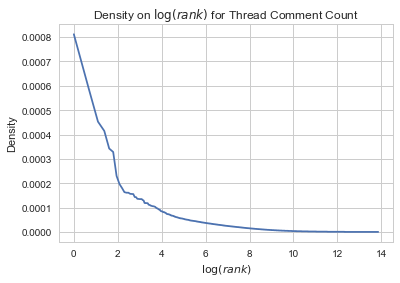

In [24]:
#then plot
plt.plot(parentFrame["logRank"],parentFrame["density"])
plt.xlabel("$\log(rank)$")
plt.ylabel("Density")
plt.title("Density on $\log(rank)$ for Thread Comment Count")

_Figure 1: Rank-Density Plot for Thread Comment Count._

We see an expected behavior in conversations. Very few threads are incredibly long, and many threads are very short. The density seems to dwindle around $e^{10} \approx 22000$ top thread counts, Which is still a sizable amount of threads for the distribution.

In [26]:
#get top thread ids
topLev = 10
topThreadFrame = parentFrame.iloc[0:topLev]
topThreadFrame

,parent_id,count,rank,density,logRank
961930,t3_5qsba5,1428,0,8.118e-04,0.000
975288,t3_61w2k1,1027,1,5.839e-04,0.693
985451,t3_6a7gb9,797,2,4.531e-04,1.099
1007941,t3_6swsuk,730,3,4.150e-04,1.386
998550,t3_6lfjbt,603,4,3.428e-04,1.609
992143,t3_6fx6lt,578,5,3.286e-04,1.792
755673,t3_1eqtrg,405,6,2.303e-04,1.946
958600,t3_5o5rhj,346,7,1.967e-04,2.079
830021,t3_2vv8ll,317,8,1.802e-04,2.197
935593,t3_56h4vf,288,9,1.637e-04,2.303


_Table 4: Our top 10 Threads by Count._

We see the most popular parent ID is associated with a [large check-in thread](https://www.reddit.com/r/depression/comments/5qsba5). In particular, this is a weekly check-in thread that is "a place to take a moment and share what is going on and how you are doing." It started around $8$ months ago, so it's surprising how robust the comment count is for this particular thread.

We see the second most popular thread is also another [weekly check-in thread](https://www.reddit.com/r/depression/comments/61w2k1/rdepression_weekly_check_in/). It is possible that we will find many of these evident in our discourse, and they suggest an environment in which individuals are looking after one another over the internet.

## Distribution of Authors

In [28]:
#get threads by comment count
authorFrame = filteredCommentFrame.groupby("author",as_index = False)[
                                                            "score"].count()
authorFrame = authorFrame.rename(columns = {"score":"count"})
authorFrame = authorFrame.sort_values("count",ascending = False)
#add rank
authorFrame["rank"] = range(authorFrame.shape[0])
#add density
authorFrame["density"] = authorFrame["count"] / authorFrame["count"].sum()
#ad log-rank
authorFrame["logRank"] = np.log(authorFrame["rank"] + 1)

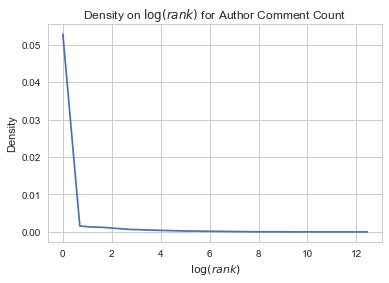

In [29]:
#then plot
plt.plot(authorFrame["logRank"],authorFrame["density"])
plt.xlabel("$\log(rank)$")
plt.ylabel("Density")
plt.title("Density on $\log(rank)$ for Author Comment Count")

_Figure 2: Authors by comment count._

We see one author hogging a huge amount of the distribution. Let's check out what this author is.

In [30]:
topAuthorFrame = authorFrame.iloc[0:topLev]
topAuthorFrame

,author,count,rank,density,logRank
116876,[deleted],92820,0,5.277e-02,0.000
87510,SQLwitch,2789,1,1.586e-03,0.693
193542,mobiuschick,2360,2,1.342e-03,1.099
222354,skyqween,2203,3,1.252e-03,1.386
196564,mytwocats11,2177,4,1.238e-03,1.609
190233,mcfattykins,2006,5,1.140e-03,1.792
13272,Bhruic,1899,6,1.080e-03,1.946
207554,poisontongue,1738,7,9.881e-04,2.079
134322,cacktastic,1637,8,9.307e-04,2.197
87345,SH2355,1546,9,8.789e-04,2.303


_Table 5: Top 10 Authors by comment count._

We see an enormous amount of observations come from deleted accounts. We can think of these as comments that are current unattributed to a particular author. While for most of our analysis, having indicators on the author likely won't matter, it will likely matter quite a bit when we do some forms of conversation modeling on our dataset.

Besides this, we see we have some commenters who exist in the $[2000,3000]$ range for number of comments. This is a sizable amount of the distribution, and suggests data sparsity in terms of the commenters that are likely to exist in the dataset.